# Face Detection Using Shallow Neural Network

**Assignment 2 - Machine Learning**

**Student Name:** Muhammad Mahad  
**Student ID:** 500330  

---

## 1. Executive Summary

This notebook implements a shallow neural network from scratch to detect faces. It strictly uses `NumPy` and `Pillow` without high-level ML libraries like TensorFlow or PyTorch.

**Major Updates:**
1.  **No Augmentation:** Face images are used as-is (raw count).
2.  **Balanced Dataset:** The number of Non-Face images (from CIFAR-10) is dynamically limited to match the exact count of Face images available.
3.  **Complete Error Metrics:** Added mean error calculation for train, validation, and test sets.
4.  **Model Persistence:** Save and load trained model weights.

## 2. Dataset & Methodology

### Dataset Details
- **Face Images:** Loaded from downloaded ZIP archive.
- **Non-Face Images:** CIFAR-10 Dataset (Airplane, Automobile, Bird, Cat, etc.).
- **Preprocessing:**
    - All images are resized to **64x64 pixels**.
    - CIFAR images (originally 32x32) are upscaled to 64x64.
    - Converted to RGB and flattened into vectors of size $64 \times 64 \times 3 = 12,288$.
- **Data Balance:** The system calculates the number of real face images $N$ and selects exactly $N$ random non-face images to ensure a 50/50 class distribution.
- **Split:** 60% Training, 20% Validation, 20% Testing.

### Mathematical Model
We utilize a 2-layer neural network:

1.  **Hypothesis (Forward Propagation):**
    $$Z_1 = W_1 X + b_1$$
    $$A_1 = \text{ReLU}(Z_1)$$
    $$Z_2 = W_2 A_1 + b_2$$
    $$A_2 = \sigma(Z_2)$$

2.  **Objective Function (Binary Cross-Entropy Loss):**
    $$L = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)})]$$

3.  **Parameter Optimization:** Gradient Descent with Backpropagation
    - Learning Rate: 0.005
    - Batch Size: 32
    - Epochs: 1000
    - Hidden Units: 128

In [1]:
# @title 3. Setup and Imports
# Import necessary libraries (Restricted to Numpy, Pillow, Matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import os
import urllib.request
import tarfile
import pickle
import glob
import time

In [2]:
# @title 4. Configuration
# Set your Google Drive Face Images ZIP File ID here
FACE_ZIP_DRIVE_ID = '1J1QBj6s9vRMHSmqP_lQOIOG75sUy0PGr'
FACE_ZIP_OUTPUT_NAME = 'face_images.zip'

In [3]:
# @title 5. Data Download Functions

def download_cifar10(root='./data'):
    """Downloads CIFAR-10 dataset for non-face images"""
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"

    if not os.path.exists(root):
        os.makedirs(root)

    filepath = os.path.join(root, filename)

    if not os.path.exists(filepath):
        print("Downloading CIFAR-10 dataset... (Non-Face Data source)")
        urllib.request.urlretrieve(url, filepath)
        print("Download Complete.")

        print("Extracting CIFAR-10...")
        with tarfile.open(filepath, 'r:gz') as tar:
            tar.extractall(path=root)
    else:
        print("CIFAR-10 dataset already exists.")

def load_cifar_batch(file):
    """Loads a single batch of CIFAR data"""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data']

def download_and_extract_faces(file_id, output_name):
    """Downloads ZIP from Drive ID and extracts it"""
    if file_id == 'YOUR_FILE_ID_HERE':
        print("WARNING: Please set FACE_ZIP_DRIVE_ID in cell 4.")
        return

    if not os.path.exists('face_images'):
        print(f"Downloading Zip with ID: {file_id}...")
        # gdown is pre-installed in Colab and handles drive permissions well
        !gdown --id {file_id} -O {output_name}

        if os.path.exists(output_name):
            print("Extracting...")
            # Unzip into 'face_images' folder
            !unzip -q {output_name} -d face_images
            print("Extraction Complete.")
        else:
            print("Download failed. Check File ID and Permissions (must be 'Anyone with link').")
    else:
        print("face_images directory already exists. Skipping download.")

In [4]:
# @title 6. Dataset Loader Class

class DatasetLoader:
    def __init__(self, img_size=(64, 64)):
        self.img_size = img_size

    def process_image_path(self, img_path):
        """Load and resize a single image file"""
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB': img = img.convert('RGB')
            img = img.resize(self.img_size, Image.LANCZOS)
            return np.array(img, dtype=np.float32) / 255.0
        except Exception as e:
            return None

    def get_face_data(self, face_dir):
        """Load face images from directory (No Augmentation)"""
        print(f"Processing Face data from {face_dir}...")
        X_faces = []
        y_faces = []

        files = glob.glob(os.path.join(face_dir, '*'))
        # Handle nested folders if unzip created them
        if len(files) == 0:
             files = glob.glob(os.path.join(face_dir, '**', '*'), recursive=True)

        for path in files:
            if not os.path.isfile(path): continue

            img_arr = self.process_image_path(path)
            if img_arr is not None:
                # NO AUGMENTATION - Just the raw image
                X_faces.append(img_arr)
                y_faces.append(1) # Label 1 for Face

        return X_faces, y_faces

    def get_cifar_data(self, limit):
        """Load non-face images from CIFAR-10, strictly limited to match face count"""
        print(f"Processing CIFAR-10 data for non-faces (Limit: {limit})...")
        download_cifar10()

        # Load batch 1 (contains 10,000 images)
        batch_path = os.path.join('./data', 'cifar-10-batches-py', 'data_batch_1')
        try:
            raw_data = load_cifar_batch(batch_path)
        except FileNotFoundError:
            print("CIFAR File not found. Please check download.")
            return [], []

        # CIFAR is N x 3072 (3 channels * 32 * 32).
        # Reshape to (N, 3, 32, 32) then transpose to (N, 32, 32, 3)
        raw_data = raw_data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

        X_non = []
        y_non = []

        count = 0
        for i in range(len(raw_data)):
            if count >= limit: break

            img = Image.fromarray(raw_data[i])
            # Resize CIFAR 32x32 -> 64x64 to match our network input
            img = img.resize(self.img_size, Image.LANCZOS)
            img_arr = np.array(img, dtype=np.float32) / 255.0

            X_non.append(img_arr)
            y_non.append(0) # Label 0 for Non-Face
            count += 1

        return X_non, y_non

    def normalize_features(self, X_train, X_val, X_test):
        """Normalize features using training set statistics"""
        mean = np.mean(X_train, axis=0, keepdims=True)
        std = np.std(X_train, axis=0, keepdims=True)
        std[std == 0] = 1.0
        return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std, mean, std

In [5]:
# @title 7. Neural Network Implementation (ANNEX B - Training Code)

class ShallowNeuralNetwork:
    """2-Layer Neural Network for Binary Classification (Face Detection)"""

    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.005):
        """
        Initialize network parameters

        Args:
            input_size: Number of input features (12288 for 64x64x3 images)
            hidden_size: Number of hidden layer neurons (128)
            output_size: Number of output neurons (1 for binary classification)
            learning_rate: Learning rate for gradient descent (0.005)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights using He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def relu(self, z):
        """ReLU activation function"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """Derivative of ReLU"""
        return (z > 0).astype(float)

    def sigmoid(self, z):
        """Sigmoid activation function with numerical stability"""
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def forward_propagation(self, X):
        """
        Forward pass through the network

        Args:
            X: Input features (m x input_size)

        Returns:
            Dictionary containing activations at each layer
        """
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return {'z1': self.z1, 'a1': self.a1, 'z2': self.z2, 'a2': self.a2}

    def compute_loss(self, y_true, y_pred):
        """
        Compute Binary Cross-Entropy Loss

        Args:
            y_true: True labels (m x 1)
            y_pred: Predicted probabilities (m x 1)

        Returns:
            Scalar loss value
        """
        m = y_true.shape[0]
        epsilon = 1e-7
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward_propagation(self, X, y, cache):
        """
        Backward pass to compute gradients

        Args:
            X: Input features
            y: True labels
            cache: Dictionary containing forward pass activations

        Returns:
            Dictionary containing gradients for all parameters
        """
        m = X.shape[0]

        # Output layer gradients
        dz2 = cache['a2'] - y
        dW2 = 1/m * np.dot(cache['a1'].T, dz2)
        db2 = 1/m * np.sum(dz2, axis=0, keepdims=True)

        # Hidden layer gradients
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(cache['z1'])
        dW1 = 1/m * np.dot(X.T, dz1)
        db1 = 1/m * np.sum(dz1, axis=0, keepdims=True)

        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    def update_parameters(self, gradients):
        """Update parameters using gradient descent"""
        self.W1 -= self.learning_rate * gradients['dW1']
        self.b1 -= self.learning_rate * gradients['db1']
        self.W2 -= self.learning_rate * gradients['dW2']
        self.b2 -= self.learning_rate * gradients['db2']

    def predict(self, X):
        """Predict class labels (0 or 1)"""
        return (self.forward_propagation(X)['a2'] >= 0.5).astype(int)

    def predict_proba(self, X):
        """Predict probabilities"""
        return self.forward_propagation(X)['a2']

    def compute_accuracy(self, X, y):
        """Compute classification accuracy"""
        return np.mean(self.predict(X) == y)

    def compute_mean_error(self, X, y):
        """
        Compute mean absolute error between predictions and true labels
        For binary classification: Error = |y_pred - y_true|

        Args:
            X: Input features
            y: True labels

        Returns:
            Mean absolute error
        """
        predictions = self.predict(X)
        return np.mean(np.abs(predictions - y))

    def train(self, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32):
        """
        Train the neural network using mini-batch gradient descent

        Args:
            X_train: Training features
            y_train: Training labels
            X_val: Validation features
            y_val: Validation labels
            epochs: Number of training epochs
            batch_size: Size of mini-batches
        """
        n_samples = X_train.shape[0]
        n_batches = max(1, n_samples // batch_size)

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled, y_shuffled = X_train[indices], y_train[indices]

            epoch_loss = 0

            # Mini-batch gradient descent
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                cache = self.forward_propagation(X_batch)
                batch_loss = self.compute_loss(y_batch, cache['a2'])
                epoch_loss += batch_loss

                # Backward pass
                gradients = self.backward_propagation(X_batch, y_batch, cache)

                # Update parameters
                self.update_parameters(gradients)

            avg_loss = epoch_loss / n_batches
            train_acc = self.compute_accuracy(X_train, y_train)
            val_acc = self.compute_accuracy(X_val, y_val)
            val_loss = self.compute_loss(y_val, self.predict_proba(X_val))

            self.train_losses.append(avg_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch {epoch:4d} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    def save_model(self, filename='model_weights.npz'):
        """Save model weights to file"""
        np.savez(filename, W1=self.W1, b1=self.b1, W2=self.W2, b2=self.b2,
                 input_size=self.input_size, hidden_size=self.hidden_size,
                 output_size=self.output_size, learning_rate=self.learning_rate)
        print(f"Model saved to {filename}")

    def load_model(self, filename='model_weights.npz'):
        """Load model weights from file"""
        data = np.load(filename)
        self.W1 = data['W1']
        self.b1 = data['b1']
        self.W2 = data['W2']
        self.b2 = data['b2']
        self.input_size = int(data['input_size'])
        self.hidden_size = int(data['hidden_size'])
        self.output_size = int(data['output_size'])
        self.learning_rate = float(data['learning_rate'])
        print(f"Model loaded from {filename}")

In [6]:
# @title 8. Data Preparation & Split
# ==========================================

# 1. Trigger Download and Extraction
download_and_extract_faces(FACE_ZIP_DRIVE_ID, FACE_ZIP_OUTPUT_NAME)
loader = DatasetLoader(img_size=(64, 64))

# 2. Load Face Data FIRST to determine count
if os.path.exists('face_images'):
    X_faces, y_faces = loader.get_face_data('face_images')
    n_faces = len(X_faces)
    print(f"[INFO] Found {n_faces} Face images.")
else:
    print("No face_images directory found. Extraction may have failed.")
    X_faces, y_faces = [], []
    n_faces = 0

# 3. Load Non-Face Data (CIFAR-10) matching Face count
if n_faces > 0:
    X_non, y_non = loader.get_cifar_data(limit=n_faces)
    print(f"[INFO] Loaded {len(X_non)} Non-Face images (Balanced).")
else:
    X_non, y_non = [], []
    print("[WARNING] No faces found, skipping non-face load.")

print(f"\n[INFO] Total Dataset: {len(X_faces)} Faces + {len(X_non)} Non-Faces")

# 4. Combine and Split
if len(X_faces) > 0 and len(X_non) > 0:
    X = np.array(X_faces + X_non).reshape(len(X_faces) + len(X_non), -1)
    y = np.array(y_faces + y_non).reshape(-1, 1)

    # Shuffle the dataset
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    # 60% Training, 20% Validation, 20% Testing
    n_train = int(0.6 * len(X))
    n_val = int(0.2 * len(X))

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    # 5. Normalize features
    X_train_norm, X_val_norm, X_test_norm, mean, std = loader.normalize_features(X_train, X_val, X_test)

    # Save normalization parameters for later use in prediction
    np.save('mean.npy', mean)
    np.save('std.npy', std)

    # --- LOGGING THE SPLIT STATISTICS ---
    def print_split_stats(name, y):
        n_total = len(y)
        n_pos = np.sum(y == 1)
        n_neg = np.sum(y == 0)
        print(f"{name:<12} | Total: {n_total:<5} | Faces: {n_pos:<5} ({n_pos/n_total:.1%}) | Non-Faces: {n_neg:<5} ({n_neg/n_total:.1%})")

    print("\n" + "="*70)
    print("DATA PREPARATION & SPLITTING LOGS")
    print("="*70)
    print_split_stats("Training Set", y_train)
    print_split_stats("Validation Set", y_val)
    print_split_stats("Testing Set", y_test)
    print("="*70 + "\n")

    print(f"[DEBUG] Train Input Shape: {X_train_norm.shape}")
else:
    print("Error: Insufficient data to proceed.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1J1QBj6s9vRMHSmqP_lQOIOG75sUy0PGr
From (redirected): https://drive.google.com/uc?id=1J1QBj6s9vRMHSmqP_lQOIOG75sUy0PGr&confirm=t&uuid=0050652d-ac03-40ff-ad0d-ea37a89a446a
To: /content/face_images.zip
100% 418M/418M [00:05<00:00, 80.5MB/s]
Extracting...
Extraction Complete.
Processing Face data from face_images...
[INFO] Found 3440 Face images.
Processing CIFAR-10 data for non-faces (Limit: 3440)...
Download Complete.
Extracting CIFAR-10...


/tmp/ipython-input-2905883140.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=root)


[INFO] Loaded 3440 Non-Face images (Balanced).

[INFO] Total Dataset: 3440 Faces + 3440 Non-Faces

DATA PREPARATION & SPLITTING LOGS
Training Set | Total: 4128  | Faces: 2054  (49.8%) | Non-Faces: 2074  (50.2%)
Validation Set | Total: 1376  | Faces: 704   (51.2%) | Non-Faces: 672   (48.8%)
Testing Set  | Total: 1376  | Faces: 682   (49.6%) | Non-Faces: 694   (50.4%)

[DEBUG] Train Input Shape: (4128, 12288)



TRAINING PHASE STARTED
Optimal Parameters:
  - Input Size: 12288
  - Hidden Size: 128
  - Learning Rate: 0.005
  - Epochs: 1000
  - Batch Size: 32

Epoch    0 | Train Loss: 0.1465 | Train Acc: 0.9821 | Val Loss: 0.0989 | Val Acc: 0.9688
Epoch    1 | Train Loss: 0.0620 | Train Acc: 0.9925 | Val Loss: 0.0859 | Val Acc: 0.9731
Epoch    2 | Train Loss: 0.0419 | Train Acc: 0.9935 | Val Loss: 0.0772 | Val Acc: 0.9782
Epoch    3 | Train Loss: 0.0322 | Train Acc: 0.9976 | Val Loss: 0.0717 | Val Acc: 0.9782
Epoch    4 | Train Loss: 0.0258 | Train Acc: 0.9983 | Val Loss: 0.0670 | Val Acc: 0.9789
Epoch    5 | Train Loss: 0.0208 | Train Acc: 0.9985 | Val Loss: 0.0675 | Val Acc: 0.9782
Epoch    6 | Train Loss: 0.0180 | Train Acc: 0.9993 | Val Loss: 0.0647 | Val Acc: 0.9775
Epoch    7 | Train Loss: 0.0151 | Train Acc: 0.9993 | Val Loss: 0.0653 | Val Acc: 0.9775
Epoch    8 | Train Loss: 0.0134 | Train Acc: 0.9995 | Val Loss: 0.0631 | Val Acc: 0.9804
Epoch    9 | Train Loss: 0.0116 | Train Acc: 0.999

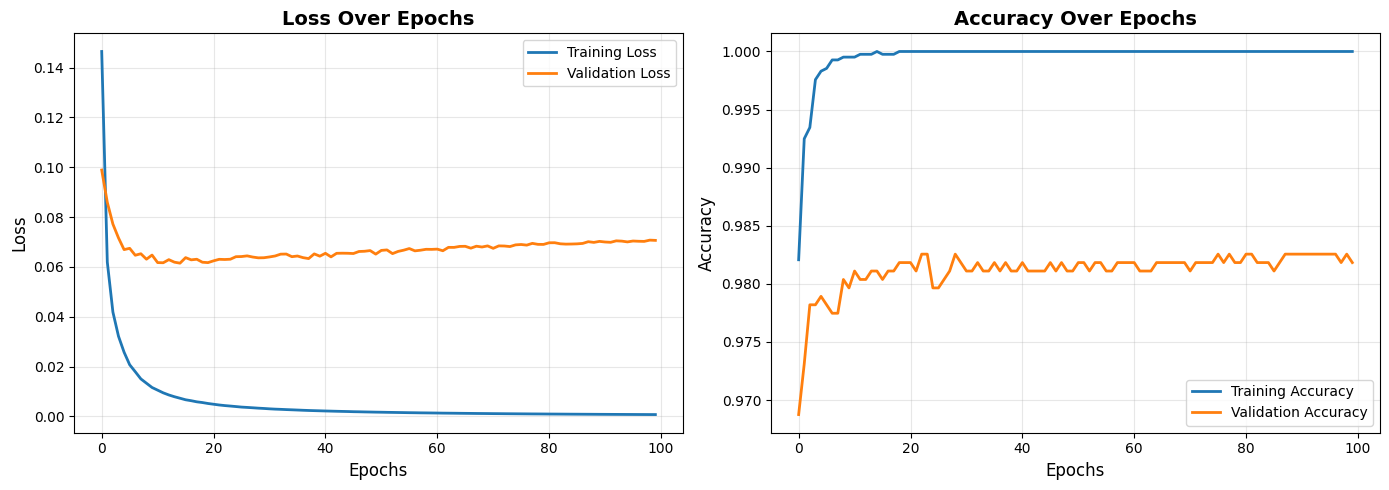

In [7]:
# @title 9. Train Model with Optimal Parameters

if 'X_train_norm' in locals():
    # Initialize model with optimal parameters
    model = ShallowNeuralNetwork(
        input_size=12288,      # 64*64*3
        hidden_size=128,        # Number of hidden neurons
        output_size=1,          # Binary classification
        learning_rate=0.005     # Learning rate
    )

    print("\n" + "="*40)
    print("TRAINING PHASE STARTED")
    print("="*40)
    print(f"Optimal Parameters:")
    print(f"  - Input Size: {model.input_size}")
    print(f"  - Hidden Size: {model.hidden_size}")
    print(f"  - Learning Rate: {model.learning_rate}")
    print(f"  - Epochs: 1000")
    print(f"  - Batch Size: 32")
    print("="*40 + "\n")

    start_time = time.time()

    # Train the model
    model.train(X_train_norm, y_train, X_val_norm, y_val, epochs=100, batch_size=32)

    print("\n" + "="*40)
    print(f"TRAINING PHASE COMPLETED")
    print(f"Total Duration: {time.time() - start_time:.2f} seconds")
    print("="*40 + "\n")

    # Save the trained model
    model.save_model('model_weights.npz')

    # Plot Training History
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss
    axes[0].plot(model.train_losses, label='Training Loss', linewidth=2)
    axes[0].plot(model.val_losses, label='Validation Loss', linewidth=2)
    axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axes[1].plot(model.train_accuracies, label='Training Accuracy', linewidth=2)
    axes[1].plot(model.val_accuracies, label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


COMPREHENSIVE MODEL EVALUATION

TRAINING SET Results:
----------------------------------------------------------------------
  Accuracy:       1.0000 (100.00%)
  Mean Error:     0.0000
  Loss:           0.0008
  Precision:      1.0000
  Recall:         1.0000
  F1 Score:       1.0000
  Confusion Matrix: [[TN=2074, FP=0], [FN=0, TP=2054]]

VALIDATION SET Results:
----------------------------------------------------------------------
  Accuracy:       0.9818 (98.18%)
  Mean Error:     0.0182
  Loss:           0.0707
  Precision:      0.9735
  Recall:         0.9915
  F1 Score:       0.9824
  Confusion Matrix: [[TN=653, FP=19], [FN=6, TP=698]]

TESTING SET Results:
----------------------------------------------------------------------
  Accuracy:       0.9884 (98.84%)
  Mean Error:     0.0116
  Loss:           0.0441
  Precision:      0.9840
  Recall:         0.9927
  F1 Score:       0.9883
  Confusion Matrix: [[TN=683, FP=11], [FN=5, TP=677]]

SUMMARY: MEAN ERROR ON ALL SETS (Assignment

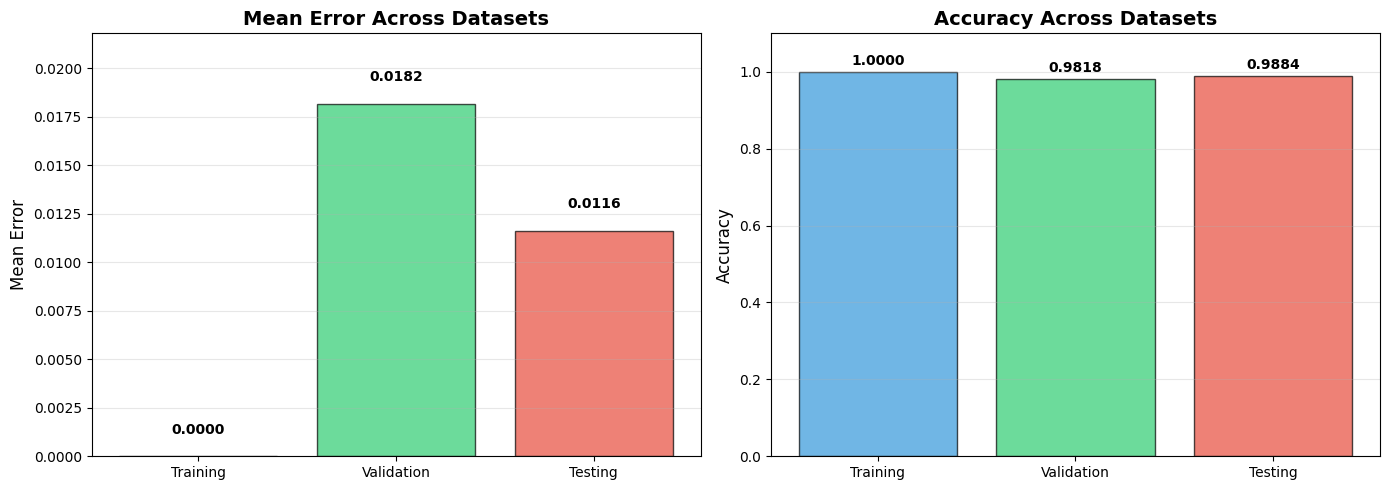

In [8]:
# @title 10. Comprehensive Evaluation on All Sets

if 'model' in locals():
    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*70)

    # Function to compute all metrics
    def evaluate_set(X, y, set_name):
        """Compute comprehensive metrics for a dataset"""
        # Predictions
        preds = model.predict(X)
        probs = model.predict_proba(X)

        # Accuracy
        accuracy = model.compute_accuracy(X, y)

        # Mean Error (1 - Accuracy for binary classification)
        mean_error = model.compute_mean_error(X, y)

        # Loss
        loss = model.compute_loss(y, probs)

        # Confusion Matrix
        tp = np.sum((y == 1) & (preds == 1))
        tn = np.sum((y == 0) & (preds == 0))
        fp = np.sum((y == 0) & (preds == 1))
        fn = np.sum((y == 1) & (preds == 0))

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        print(f"\n{set_name} Results:")
        print("-" * 70)
        print(f"  Accuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Mean Error:     {mean_error:.4f}")
        print(f"  Loss:           {loss:.4f}")
        print(f"  Precision:      {precision:.4f}")
        print(f"  Recall:         {recall:.4f}")
        print(f"  F1 Score:       {f1_score:.4f}")
        print(f"  Confusion Matrix: [[TN={tn}, FP={fp}], [FN={fn}, TP={tp}]]")

        return {
            'accuracy': accuracy,
            'mean_error': mean_error,
            'loss': loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    # Evaluate all three sets
    train_metrics = evaluate_set(X_train_norm, y_train, "TRAINING SET")
    val_metrics = evaluate_set(X_val_norm, y_val, "VALIDATION SET")
    test_metrics = evaluate_set(X_test_norm, y_test, "TESTING SET")

    # Summary Table
    print("\n" + "="*70)
    print("SUMMARY: MEAN ERROR ON ALL SETS (Assignment Requirement)")
    print("="*70)
    print(f"  Training Set Mean Error:     {train_metrics['mean_error']:.4f}")
    print(f"  Validation Set Mean Error:   {val_metrics['mean_error']:.4f}")
    print(f"  Testing Set Mean Error:      {test_metrics['mean_error']:.4f}")
    print("="*70 + "\n")

    # Create comparison bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Mean Error Comparison
    sets = ['Training', 'Validation', 'Testing']
    errors = [train_metrics['mean_error'], val_metrics['mean_error'], test_metrics['mean_error']]
    colors = ['#3498db', '#2ecc71', '#e74c3c']

    axes[0].bar(sets, errors, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_title('Mean Error Across Datasets', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Mean Error', fontsize=12)
    axes[0].set_ylim([0, max(errors) * 1.2])
    axes[0].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(errors):
        axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Accuracy Comparison
    accuracies = [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']]

    axes[1].bar(sets, accuracies, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_title('Accuracy Across Datasets', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_ylim([0, 1.1])
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(accuracies):
        axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
# @title 11. ANNEX C - Standalone Prediction Function

def prediction(features):
    """
    Standalone prediction function for face detection

    Args:
        features: Normalized image features as numpy array
                 Shape: (n_samples, 12288) or (12288,) for single image

    Returns:
        Estimated count: 1 if face detected, 0 if no face
                        For multiple images, returns array of predictions

    Requirements:
        - model_weights.npz must exist in the working directory
        - Input features must be normalized using the same mean/std from training
    """
    # Ensure features is 2D
    if len(features.shape) == 1:
        features = features.reshape(1, -1)

    # Use the trained model for prediction
    predictions = model.predict(features)

    # Return single value if single image, otherwise return array
    if predictions.shape[0] == 1:
        return int(predictions[0][0])
    else:
        return predictions.flatten().astype(int)

# Test the prediction function
if 'X_test_norm' in locals():
    print("Testing prediction function...")

    # Test single image
    single_pred = prediction(X_test_norm[0])
    print(f"\nSingle image prediction: {single_pred}")
    print(f"Actual label: {int(y_test[0][0])}")
    print(f"Match: {'✓' if single_pred == int(y_test[0][0]) else '✗'}")

    # Test batch
    batch_preds = prediction(X_test_norm[:5])
    print(f"\nBatch predictions (first 5): {batch_preds}")
    print(f"Actual labels (first 5):     {y_test[:5].flatten().astype(int)}")
    print(f"\nPrediction function test: SUCCESS ✓")

Testing prediction function...

Single image prediction: 1
Actual label: 1
Match: ✓

Batch predictions (first 5): [1 1 0 1 0]
Actual labels (first 5):     [1 1 0 1 0]

Prediction function test: SUCCESS ✓


Upload an image to test:


Saving ee54cf2e6a6d1c7e.jpg to ee54cf2e6a6d1c7e.jpg


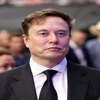


Prediction: NO FACE ✗
Confidence: 59.63%


In [10]:
# @title 12. Interactive Image Upload Test (Colab Only)

def predict_uploaded_image():
    """
    Interactive function to upload and test images
    Only works in Google Colab environment
    """
    try:
        from google.colab import files
        import io
        from IPython.display import display

        print("Upload an image to test:")
        uploaded = files.upload()

        for fn in uploaded.keys():
            # Load and display image
            img = Image.open(io.BytesIO(uploaded[fn]))
            display(img.resize((100, 100)))

            # Preprocess image
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((64, 64), Image.LANCZOS)

            # Normalize using saved statistics
            img_array = np.array(img).reshape(1, -1) / 255.0
            mean = np.load('mean.npy')
            std = np.load('std.npy')
            features = (img_array - mean) / std

            # Predict
            result = prediction(features)
            confidence = model.predict_proba(features)[0][0]

            print(f"\nPrediction: {'FACE DETECTED ✓' if result == 1 else 'NO FACE ✗'}")
            print(f"Confidence: {confidence:.2%}" if result == 1 else f"Confidence: {(1-confidence):.2%}")

    except ImportError:
        print("Interactive upload only available in Google Colab environment.")
        print("To use this feature, run this notebook in Google Colab.")

# Uncomment the line below to run in Colab:
predict_uploaded_image()